## Load packages

In [1]:
# Useful packages
import os
import warnings

# Work with Python array and graphs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cluster tendency
from pyclustertend import hopkins

# Mapping
from sklearn.metrics import pairwise_distances, accuracy_score
from coclust.evaluation.external import accuracy
from skbio.stats.ordination import pcoa
from multiview.mvmds import mvmds

# Clustering algorithm
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
#from KMedoidsPaper import KMedoids

# Clustering performance evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==0.22.1
numpy==1.17.0
matplotlib==3.2.1


## Load data

In [3]:
def loadShapedMatrix(mat,studiedPeriods,studiedClasses):
    # Load data from CSV
    nameEnd = ("%s" %studiedClasses).replace("[", "")
    if ('%s.csv' %(nameEnd))[0] == " ":
        nameEnd = ('%s' %(nameEnd))[1:] # remove first space if there is
    nameEnd = ("%s" %nameEnd).replace("]", "")
    nameEnd = ("%s" %nameEnd).replace(" ", "  ") # 1 space -> 2 spaces ; 2 spaces -> 4 spaces
    nameEnd = ("%s" %nameEnd).replace("    ", "   ") # 4 spaces -> 3 spaces
    nameStart = ("%s" %studiedPeriods).replace("[", "")
    nameStart = ("%s" %nameStart).replace("]", "")
    nameStart = ("%s" %nameStart).replace(" ", "  ")

    print(('school_%s%s_%s.csv' %(mat,nameStart,nameEnd)))
    print('school_EDA1_1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17')
    ISC = np.genfromtxt(os.path.join('school_%s%s_%s.csv' %(mat,nameStart,nameEnd)),delimiter=',')
    ISC = np.array(ISC,dtype='float') # Convert into array

    # Initialize reshaped ISC
    nParticipants = ISC.shape[0]
    nPeriod = int(np.sqrt(ISC.shape[1] / nParticipants))
    ISC_sh = np.zeros((ISC.shape[0]*nPeriod,ISC.shape[0]*nPeriod))

    # Reshape data by moving blocks
    for period1 in range(nPeriod):
        for period2 in range(nPeriod):
            if (period1 == period2): # We must symmetrize this block containing NaNs
                subISC = np.nan_to_num(ISC[:,nParticipants*(nPeriod*period1+period2):nParticipants*(nPeriod*period1+period2+1)])
                subISC = (subISC+subISC.T)/2
            else:
                subISC = ISC[:,nParticipants*(nPeriod*period1+period2):nParticipants*(nPeriod*period1+period2+1)]
            
            ISC_sh[nParticipants*period1:nParticipants*(period1+1),nParticipants*period2:nParticipants*(period2+1)] = subISC

    # Make reshaped ISC symmetrical
    ISC_sh = np.nan_to_num(ISC_sh)
    ISC_sh = (ISC_sh+ISC_sh.T)/2

    return ISC_sh,nPeriod,nParticipants


# To study : DONT USE LINSPACE OR ARANGE BUT HAND WRITTEN ARRAY, OTERHWISE WILL NOT FIND THE CSV
studiedPeriods = np.array([1])
#studiedPeriods = np.array([1,4])

studiedClasses = np.array([1,4])
studiedClasses = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])


print(('%s.csv' %(studiedClasses)))
# Load EDA and IBI
ISC_EDA,nPeriod,nParticipants = loadShapedMatrix('EDA',studiedPeriods,studiedClasses)
#ISC_IBI,nPeriod,nParticipants = loadShapedMatrix('IBI',studiedPeriods,studiedClasses)
ISC_IBI = ISC_EDA
# Remove rows with NaNs
def removeNaNSubject(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    return new_mat

# Remove participant in vector
def removeSubjectsVector(vector,subjects):
    new_vect = np.copy(vector)
    for subj in subjects:
        new_vect = np.delete(new_vect, (subj), axis=0)
    
    return new_vect

# Remove rows in ISC if NaN
def removeNaNISC(ISC):
    last_i = 0
    i = 0
    subjectsRemoved = []
    remove = False
    nbTotal = len(ISC) 
    while (last_i < nbTotal and i < nbTotal - 1):
        for i in range(nbTotal):
            remove = False
            for p in range(nPeriod):
                if ISC[p*nParticipants,i] == 0.:
                    remove = True
                    break

            if remove:        
                ISC = removeNaNSubject(ISC,i)
                last_i = i
                nbTotal -= 1
                subjectsRemoved.append(i)
                break
                
    print(subjectsRemoved)
    return ISC, subjectsRemoved

    #print(last_i)

    
    
ISC_EDA,subjectsRemoved_EDA = removeNaNISC(ISC_EDA)
ISC_IBI,subjectsRemoved_IBI = removeNaNISC(ISC_IBI)



import csv
    
with open(os.path.join('test.csv'), 'w') as File:
    writer = csv.writer(File,delimiter =',')
    writer.writerows(ISC_EDA)        
        


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].csv
ok*
False
1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17].csv
school_EDA1_1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17.csv
school_EDA1_1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
[17, 17, 51, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68]
[17, 17, 51, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68]


## Compute distance matrix

In [4]:
def computeDistanceMatrix(study_matrix):
    
    # Normalise maximum value to 1
    normed_matrix = np.copy(study_matrix)
    normed_matrix = normed_matrix / np.max(abs(normed_matrix))
    
    # Convert into distance matrix
    distance_matrix = np.sqrt((1-normed_matrix)) # Formula in Matlab and in Scikit to convert 
        
    # Interval MDS normalization to spread values between 0 and 1
    a = np.min(np.sort(distance_matrix,axis=0)[1,:])
    distance_matrix = distance_matrix - a
    distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))
    distance_matrix = distance_matrix / np.max(distance_matrix)
    
    # To make sure output is perfectly symmetrical
    return (distance_matrix+distance_matrix.T)/2

## Multiview mapping

In [5]:
def computeAllDistanceMatrix(ISC_EDA,ISC_IBI):
    
    # Make copy of 2 matrices (for each modality)
    mat_EDA = np.copy(ISC_EDA)
    mat_IBI = np.copy(ISC_IBI)
    
    # Compute the 2 distance matrices (according to each modality)
    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(ISC_IBI)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(mat_EDA)):
        mat_EDA[i,i] = 0
    for i in range(len(mat_IBI)):
        mat_IBI[i,i] = 0
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')
    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')

    # Return distance matrices
    return distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI


In [6]:
def computeCoordinate(mat=['EDA','IBI','corrEDA','corrIBI'],added=False):

    # Compute all distance matrices
    distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    #distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    # Choose which matrices to include into the multiview
    multiviewMat = []
    if ('EDA' in mat):
        multiviewMat.append(distance_matrix_EDA)
        distance_matrix = distance_matrix_EDA
    if ('IBI' in mat):
        multiviewMat.append(distance_matrix_IBI)
        distance_matrix = distance_matrix_IBI
    if ('corrEDA' in mat):
        multiviewMat.append(distance_matrix_corr_EDA)
    if ('corrIBI' in mat):
        multiviewMat.append(distance_matrix_corr_IBI)
        
    # Compute mapping
    embeddingDim = dim # to have a 2D map
    
    if len(mat)==1:
        points = np.array(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).samples)
        print("pcoa proportion explained : %s " %np.sum(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).proportion_explained))
    else:
        points = mvmds(multiviewMat,len(mat)*[True],embeddingDim,added=added)
    
    return points

In [7]:
import umap.umap_ as umap
from sklearn import preprocessing

def computeUMAPCoordinate(mat,sslLabel=None,n_neighbors=3):

    if (mat==['EDA']):
        study_matrix = ISC_EDA
    if (mat==['IBI']):
        study_matrix = ISC_IBI

    fitter = umap.UMAP(n_components=int(dim),n_neighbors=n_neighbors,metric='correlation',min_dist=0.0,init='spectral',target_weight=0.5,n_epochs=5000).fit(study_matrix,sslLabel)
    #points = preprocessing.scale(fitter.embedding_,axis=0)
    points = (fitter.embedding_ - np.mean(fitter.embedding_,axis=0)) / np.std(fitter.embedding_,axis=0)
    #print(np.std(points))
    #print(np.mean(points))
    return points

In [8]:
from sklearn.cluster import SpectralClustering

def computeSCCoordinate(mat,gamma=1):
    
    distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    #distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    if (mat==['EDA']):
        distance_matrix = distance_matrix_EDA
    if (mat==['IBI']):
        distance_matrix = distance_matrix_IBI
    
    
    clusteringDist = SpectralClustering(n_clusters=dim+1, n_init=10,affinity='precomputed')
    affinity_matrix = np.exp(-gamma * distance_matrix ** 2)
    clusteringDist.fit(affinity_matrix)
    return clusteringDist.map_[:,1:]

In [9]:
from sklearn.cluster import SpectralClustering

def computeNoneCoordinate(mat):
    
    distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    #distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    if (mat==['EDA']):
        distance_matrix = distance_matrix_EDA
    if (mat==['IBI']):
        distance_matrix = distance_matrix_IBI
    
    return distance_matrix

## Compute clustering

In [10]:
class Results():

    def __init__(self,mat,mapping,algo,condition):
        self.mat = mat
        self.mapping = mapping
        self.algo = algo
        self.condition = condition
        
    def twoClustersMethodResult(self):
        print("Blind results\n")
        
        # Cluster tendency
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        
        # Found clusters
        print("Found clusters ")
        print(self.label)
        
        # Clustering quality evaluation
        print("Silhouette coefficient : %0.3f" %self.silhouetteCoef())
        print("DB index : %f " %self.dbScore())
                
        # Comparing to ground truth (if known)
        if (os.path.isfile(os.path.join('conditionSchool_EDA.csv')) and os.path.isfile(os.path.join('conditionSchool_IBI.csv'))):
            global groundTruth
            if (groundTruth):
                print("\n\nComparing to ground truth\n")
                print("Accuracy : %f " %self.accuracy())
                #print("Well participants : [%s]" % ", ".join(map(str, self.wellClassified)))        
                print("Misclassified participants : [%s]" % ", ".join(map(str, self.misClassified)))        

    def applyMethod(self,method):
        
        # Mapping
        if (mapping == 'UMAP'):
            points = computeUMAPCoordinate(self.mat)
        elif (mapping == 'MDS'):
            points = computeCoordinate(self.mat,added=False)
        elif (mapping == 'MDS_scale'):
            points = computeCoordinate(self.mat,added=True)
        elif (mapping == 'SC'):
            points = computeSCCoordinate(self.mat)
        elif (mapping == 'None'): # distance matrix based clustering algorithm
            print("dist meth")
            points = computeNoneCoordinate(self.mat)
            if (algo == 'Spectral Clustering distance'):
                points = np.exp(-method.gamma * points ** 2)
        
        # Clustering
        # if (meth.distance_matrix):
        if (algo == 'K-Medoids'):
            meth = method.fit(pairwise_distances(points))
        else:
            meth = method.fit(points)

        # Store found labels and points location
        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)
            
        self.label = label
        self.best_points = points
         
    def showResultMap(self):
        
        # Set new figure
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        
        # Annotate points
        if mat == ['EDA']:
            n = len(ISC_EDA)
        elif mat == ['IBI']:
            n = len(ISC_IBI)        
        for i in range(n):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))     
    
        # Show color according to trueDisplay bool
        global trueDisplay
        if (trueDisplay):
            # Scatter points
            for i in range(n_clusters):
                ax.scatter(self.best_points[self.trueGroups[i],0],self.best_points[self.trueGroups[i],1],s=145,label=str(i))
            
            # Add legend
            TP = mpatches.Patch(color='blue', label='NA')
            TN = mpatches.Patch(color='red', label='SSA')
            FP_FN = mpatches.Patch(color='black', label='misclassified')
            #plt.legend(handles=[TP,TN,FP_FN])
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            #plt.axis('off')
            #axes = plt.gca()
            #axes.set_xlim([-0.4,0.4])
            #axes.set_ylim([-0.4,0.7])
            plt.savefig(os.path.join('figures','GT_%s.png' %self.mat),bbox_inches='tight')
        else:
            # Scatter points
            for i in range(n_clusters):
                ax.scatter(self.best_points[self.label == i,0],self.best_points[self.label == i,1],s=145,label=str(i))
            
            # Add legend
            group0 = mpatches.Patch(color='darkgreen', label='First group')
            group1 = mpatches.Patch(color='darkorange', label='Second group')
            #plt.legend(handles=[group0,group1])       
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            #plt.axis('off')
            plt.savefig(os.path.join('figures','clustering_%s.png' %self.mat),bbox_inches='tight')

        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EDA):
            warnings.warn("Each participant correspond to one label")
            return -1
        elif len(np.unique(self.label))==len(ISC_IBI):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        if mat == ['EDA']:
            n = len(ISC_EDA)
        elif mat == ['IBI']:
            n = len(ISC_IBI)
        for p in range(100):
            H.append(hopkins(self.best_points,n)) 
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    def silhouetteCoef(self):
        # Compute Silhouette Coefficient based on distance matrix (the closer it is to 1, the better the clustering is)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EDA):
            warnings.warn("Each participant correspond to one label")
            return -1
        elif len(np.unique(self.label))==len(ISC_IBI):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')
        
    def accuracy(self):
        self.trueGroups = []
        for i in range(n_clusters):
            self.trueGroups.append(np.where(self.condition == i)[0])
        
        # Find which participants are misclassified and compute accuracy
        if mat == ['EDA']:
            subjects = np.arange(len(ISC_EDA))
        elif mat == ['IBI']:
            subjects = np.arange(len(ISC_IBI))
        self.wellClassified = subjects[self.label==condition]
        self.misClassified = subjects[self.label!=self.condition]
        '''if (len(self.misClassified) > len(self.wellClassified)):
            self.wellClassified, self.misClassified = self.misClassified, self.wellClassified
        
        return len(self.wellClassified) / len(ISC_EDA)
        '''
        print(len(ISC_IBI))
        print(self.condition)
        print(self.label)
        return accuracy(self.condition,self.label)

In [11]:
# Choose which matrix or matrices to study
mat = ['EDA']
#mat = ['EDA','IBI']

# Decide if compare to ground truth
groundTruth = True

# Display found clusters or true clusters with misclassified participants in black
trueDisplay = True

# Choose mapping method
#mapping = 'UMAP'
#mapping = 'MDS'
#mapping = 'MDS_scale'
mapping = 'SC'
#mapping = 'None'

# Choose clustering algorithm
algo = 'K-Means'
#algo = 'Spectral Clustering'
#algo = 'Hierarchical Clustering'
#algo = 'K-Medoids'

#algo = 'Spectral Clustering distance'
#algo = 'Hierarchical Clustering distance'

In [12]:
# Read true labels from CSV file
condition = np.genfromtxt(os.path.join('conditionSchool_%s.csv' %mat[0]),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
print(condition)
condition = condition*sum([condition==studiedClasses[i] for i in range(len(studiedClasses))])
print(condition)

import scipy.stats as ss
condition = condition[condition!=0]
print(condition)

condition = ss.rankdata(condition,method='dense')
print(condition)

nClusters = len(np.unique(condition))
nPeriod = len(studiedPeriods)
nParticipants = len(condition)
    
if mat == ['EDA']:
    condition_EDA = removeSubjectsVector(condition,subjectsRemoved_EDA) - 1
    condition = condition_EDA
elif mat == ['IBI']:
    condition_IBI = removeSubjectsVector(condition,subjectsRemoved_IBI) - 1
    condition = condition_IBI
    


[ 1  1  1  1  1  1  1  1  1  1  2  2  3  4  4  4  4  4  5  5  5  6  6  6
  6  7  7  7  8  8  8  8  8  9  9  9  9  9 10 11 11 11 11 11 11 11 11 11
 11 11 12 12 12 12 12 13 13 13 13 13 13 13 14 15 15 15 15 15 15 15 16 16
 16 16 16 16 16 16 16 16 17 17 17 17 17]
[ 1  1  1  1  1  1  1  1  1  1  2  2  3  4  4  4  4  4  5  5  5  6  6  6
  6  7  7  7  8  8  8  8  8  9  9  9  9  9 10 11 11 11 11 11 11 11 11 11
 11 11 12 12 12 12 12 13 13 13 13 13 13 13 14 15 15 15 15 15 15 15 16 16
 16 16 16 16 16 16 16 16 17 17 17 17 17]
[ 1  1  1  1  1  1  1  1  1  1  2  2  3  4  4  4  4  4  5  5  5  6  6  6
  6  7  7  7  8  8  8  8  8  9  9  9  9  9 10 11 11 11 11 11 11 11 11 11
 11 11 12 12 12 12 12 13 13 13 13 13 13 13 14 15 15 15 15 15 15 15 16 16
 16 16 16 16 16 16 16 16 17 17 17 17 17]
[ 1  1  1  1  1  1  1  1  1  1  2  2  3  4  4  4  4  4  5  5  5  6  6  6
  6  7  7  7  8  8  8  8  8  9  9  9  9  9 10 11 11 11 11 11 11 11 11 11
 11 11 12 12 12 12 12 13 13 13 13 13 13 13 14 15 15 15 15 15 15 15 16 16
 

17
17
Blind results

Hopkins test
0.650749 +- 0.020572
Found clusters 
[ 2  5 12 13  0 15 11  5  6  1  9 11 14  4 10  8 12  9  0 10  3  8 16  5
 11  5  5  0  5 10 14 12  3  0  4 16  4  9  4 13 16  0 16 10  1  4 16  4
  6 12  7 10 11 16  1  4  3  5 16  0  3  3  0  4  9  3 12  0  3  0  7]
Silhouette coefficient : 0.431
DB index : 0.549871 


Comparing to ground truth

71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 2  5 12 13  0 15 11  5  6  1  9 11 14  4 10  8 12  9  0 10  3  8 16  5
 11  5  5  0  5 10 14 12  3  0  4 16  4  9  4 13 16  0 16 10  1  4 16  4
  6 12  7 10 11 16  1  4  3  5 16  0  3  3  0  4  9  3 12  0  3  0  7]
Accuracy : 0.281690 
Misclassified participants : [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 

//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


'\nfrom sklearn.metrics import homogeneity_score\ncondition = np.genfromtxt(os.path.join(\'conditionSchool_%s.csv\' %mat[0]),delimiter=\',\')\ncondition = np.array(condition,dtype=\'int\') # Convert into array\nif mat == [\'EDA\']:\n    condition = removeSubjectsVector(condition,subjectsRemoved_EDA)\nelif mat == [\'IBI\']:\n    condition = removeSubjectsVector(condition,subjectsRemoved_IBI)\nprint("homogeneity")\nprint(homogeneity_score(condition,method_result.label))\n'

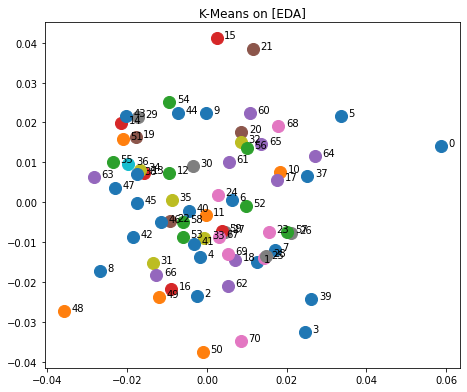

<Figure size 432x288 with 0 Axes>

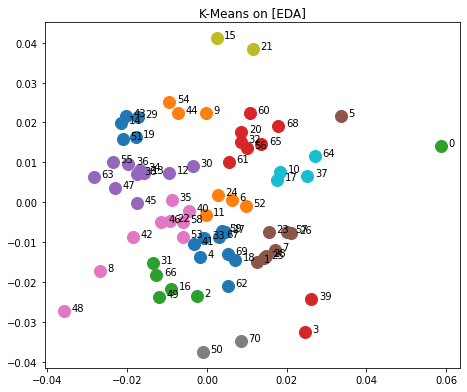

In [13]:
# Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo,condition=condition)
n_clusters = nClusters*nPeriod
print(n_clusters)
print(nClusters)
dim = 2

if (algo == 'K-Means'):
    method = KMeans(n_clusters=n_clusters,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=n_clusters,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward")
    
elif (algo == 'Spectral Clustering distance'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1,affinity='precomputed')
elif (algo == 'Hierarchical Clustering distance'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="single",affinity='precomputed')
#elif (algo == 'Hierarchical Clustering distance'): # ward doesnt work with precomputed matrix
#    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward",affinity='precomputed')
        
method_result.applyMethod(method)

# Show results
method_result.twoClustersMethodResult()
method_result.showResultMap()

plt.figure()
groundTruth = False
trueDisplay = False
method_result.showResultMap()

'''
from sklearn.metrics import homogeneity_score
condition = np.genfromtxt(os.path.join('conditionSchool_%s.csv' %mat[0]),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
if mat == ['EDA']:
    condition = removeSubjectsVector(condition,subjectsRemoved_EDA)
elif mat == ['IBI']:
    condition = removeSubjectsVector(condition,subjectsRemoved_IBI)
print("homogeneity")
print(homogeneity_score(condition,method_result.label))
'''

## Change dim

In [14]:
# Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo,condition=condition)
accDim = []
allDim = np.arange(2,int(nParticipants/3))

if (algo == 'K-Means'):
    method = KMeans(n_clusters=n_clusters,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=n_clusters,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward")

for dim in allDim:
    method_result.applyMethod(method)
    accDim.append(method_result.accuracy())

71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[10  2  7  8  0  5 14  2  4 16 11 14  1  6 12  9  7 11  0 12  3  9 15  2
 14  2  2  0  2 12  1  7  3  0  6 15  6 11  6  8 15  0 15 12 16  6 15  6
  4  7 13 12 14 15 16  6  3  2 15  0  3  3  0  6 11  3  7  0  3  0 13]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 6 11 13 12 16 10  0  0 15  5 10  4  4  1  1  5  3 10  0  7 10  5  4 11
  4  0  0  9  0  8  4  3  2  3  8  4  8 14  8 12  4  3  3  1  5  4  3  1
 15  3 13  1 11  3  5  8  2 11  3  0  2  2  9  1 10  2  3 16  2  9 12]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 7 14 14 14  0 16 15  4  3  1  1 12 12 12  6  1 10  1 15  5  1 16  3  2
 12  4  4  8  4 13 12 10  1 10  5 12 13  8  5  4 12 10 10  6 13  3 15  3
 11 11  2  6  1 10  5  5  1  8 10 10  9  1  2  6  9  1  0  0  9  2  4]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[10  1  1  1  4 10  8  2  6  0  9 16  5  6  6  0  4  7  1 13  0  0  1 16
  5  2  2  3  2 14 15  8 15  4  4  5 14  3  8  2 16  4  8  5 14  6  4  6
 11 11 16 14  9  4  0 14  9 15  4 13  7  9 16  5  7 15 13 13  7 16 12]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[13  1  1  1  5  3 16  5  1 15  0  1  4  4  4  9  8 11 16  6 15  3  1  2
  2  8  5  1  0 14 11  7 11  8 15  2 15 13  6  5  4  8  7  9 14  4 16  4
  7 10  1  9  0  8 15 15  0 11  8  8 14  0  8  2 12 11  7  5 14  1 10]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[16  6  6  3  8 15  2  3  9  5  4  6 10  0  0  5  7  1  2  8 15 15  9  7
 11  7  3  6  7  5  1  9  1  7  2 11  5 16  8  3 10 10  9 14 13  0  2 10
  9 12  6 14  4  7  5  5  4  1  7  1 13  4  4 14  1 11  1  3 11  6 12]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 6  3  2  2 10  4  7 12  8  9 10  2 15  8  8  9  0 13  0 12  4  4  7 13
  1  0  0  2  0  9 15  7 15  0  5  1  9  1 11  2 15  3  7 11 11  8  5  8
  1 16  2 11 10  0  9  9 10 15  0  3 13  0  0 15 14  1  3 12  1  2 16]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[16  5  5  5  7 10  6  4  6  1  8  0 12 13 13  1 14  4  7 15  4 10  6  4
  2 14 14  5  4  1  3  6  3  7 13  6  1  2 11  5  7  4  6  0  0 13 13 12
  6  9  5 11  8  7  1  1  8  3 13 12  0  8  8  3  3  2 12  4  9  5  5]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[14  1  1  1 11  7 12  5 12 13  3  9 16 10 10  4  3  6  8 11  5  7 12  5
 13  8 15  1  5  4 16 12 16  8  0  2  4 12 11  1  8  8 12  9  4 10  0  6
  2  2  1  9  3  8  4  4  8 16  5  6  8  4  3  2 16 13  6  5  2  2  1]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[12  5  7  7  5 15 14  6 14 10  3  1  9  4  4 11  3  2  8  2 15 15 14  6
  6  8  2 14  6 10  9 14  9  8  4 13 10 14 14  7  8  8 14  1 11  5  4  9
 13  0  7  1 16  5 10  5 16  9  4  2  5 16  3 13  0  6  2  2  0  7  7]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 1  4 14  7  4 12  5  9 10 13  8 14  6  0  0 13 15  3 11  3  3 12 10  2
  2 15 15  7  9 13  6  5  4  1  0  5 13 10 16  1 11 11  5 13 13  0  7  6
  5  3 14 13  1  4 16  0  1  6  0  6  1  1  8  5  2  2  3  3 13 14 14]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 9  5  5  9  6  9 15  5  7  6  9  1  2 14 14 13 11  0 10  8  8  8  7  4
  4 11 11  1  5  1  2 15  2  6 15 15  6  7  1 16 10  8 15  1 13  6  8  2
 15  0 16  1  3  6  6  6 13  2 14  2 13  3 14 15 12  4  0  0  0 16  0]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 0  7  7 13  9  3  1  7  1 10  6  2 10 12 12 16  8  5 14  3  3  3  1  4
  4  5  5 10  5  2 10  1  7  9  9  1  9  1  2 11 14  5  1  2 16  9 13  9
  9 15 11  2  8  9  9  9  9 10 12  5 16  8  8  2  5  4  5  5  5  2 15]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[16  3  5 13  0  8  1  2  5  9  9  4 12 12 12 15  9  7 14  7  7  8 10 12
 15  9  8  0  2 12  9  1  3  6  9 10  9 10  0  6 14 14 10  4 15  6  5  9
 10 15 13  0 11  6  1  9  6  5 12  9  6  6 11 10 15 12  7  7 15  4  5]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[10  8  6  9  8  4  3  1  6  1 16  6  5 12  8  2 12  5 11  5 14 14  3  8
  3  9  4  9  1 14 15  3 13  8  1  3  8  3  0  8 11 11  3  6  2  8  1  4
  3  5  6  0 12  8  7  8  8 13 12  5  8 12 12  3 13 13  5  5  2  6  6]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 8 15  2  4 16  7 14  2  2  3 12  2  7 10 10  4 16  9 13  9  7  7  5  1
  1  4  9  4 16 16  3  5 15  8  6 11 16  5  7  8 13  2  5 10 16  8  2  0
 11 11 15  5 16  8 14 16  8  1  1 15  8  8  1 11 16  1  9  9 11 11  2]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 5  7 14  4  8 11  0 14 14 12 12 15  3  9  6  4  4  1 10  8  8 11 13  6
  6  4 11  4 16 16 12 14  7  5  2  2 12 13  8  1 10 10 13 15 15  5 12  3
  2  2  5  8 14  5  0  4  5 14  6  3  5  5  9  2  6 13  3  1  2  2 14]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 6 11  3  8  7 14  5  3  3  2  2 12 16  4  4  6  2 14 14  9  9 12  0 13
 13  8  9  8  2  2  2  2 11  7  2 15  2  6  1 14 10 10  0 12  2  7  2 12
  2  9  7  1  2  7  5  2  7  3  3 16  7  7  4 15  6  4 16  9  6 12  3]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[12  5  2 11  9  1  1  3  7 13 12  2  0  8  8 16 11  8 10  4  0  0  6  8
 15 11  1 14  3  7 13  4  5 12 16  7 16  6  4 12 10 10  6  7 12 16 13  7
  2  2  2  4 11  3  7 16 12  5  3  3  3  3 14  8  5  6  3  1  2  2  2]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[15 16 12  6 16  6  5 12 12  9 16  3  0  0  0  6 11  6 14  5  2  5 10  0
  4  6  2  6  4  4  9  4  5  1  5 13  4 10  5 16  8  8 10  3 16  7  9  7
  7  3  3 10 11 16  1  7 16 12 12  1 16 11 11 13  6 10  5  2  3  3  3]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 0 14  9  3  5  2 10  9  9  3  5 11  6 15 15  5  1  3 13  7  2  2  8 14
  4  7 12 11  1  1 11  1  6  5  1  5  1  8  4  5 13 13  8 11  5 11  3 11
  7 12  7  4 14 16 11  1  5  6  9  7  5 14 16 13  1 15  7 12 10 11 10]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 5 14  5  9  1  4 13  5  9  9  8  4 10  6  6 15 14  2  7  2  2  4 11 12
 12  3 13  4  5  2  4 11 10  0  2  4  4 11 11  1  7  7 11  4 15  4  9  4
  2  2  3 11  1 14  0 14  0 10  6  3 15 14 16 10  3  6  3  2  4  4 13]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 8  5 13  0 15  2  7 13 13  0  0  2  4  9  9 16  5  6 10 14  6  2 11  5
  3  5 16  2 13  2  2 13  4  7 14  2  1  8  3  2 10 10 11  2  2 12  0 13
 12  1 11  3 15  2  7 16  7  4  9 11  2  5  9 10 11  9 11  1  1 13  1]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 2 10 13  2  4  2  9 13 13 13 14 11  5  1 12  4  3  0  2  4 15  2  6 12
 13 13 15  6 13  5 16 13 16  9  4  0  3  8  4  2  7  7  5 11 11  8 13 13
  8 15  6 13  3  6  9  4 12 16 13  6 12 12  1  0  3  1  6 15  3 13 15]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[ 0  1 13  3  1 14  4  7 13  9 11 11  7 12 12  2  8  8  8 14 12 14  7  2
  2  7  4  3  8 14  9  2  6 10 14 15  8  3  2  1 16 16  7 14 11  2  9  8
  2  4  7 11  1  0 10  2  0  6 13  7  9  2  3 15  8  5  7  4  4  4  4]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


71
[ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4  4  5  5  5  5  6
  6  6  7  7  7  7  7  8  8  8  8  8  9 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 12 12 12 12 12 12 12 13 14 14 14 14 14 14 14 16 16 16 16]
[11  4 13  4 14 11 16  9  2  2  2  5  7  7  7 14 13 11 11  0  4  0  4  7
 14  5 16  6  9  0 15 11 15 10  0 15  1  3 14 11 10 10  7  0  5  3  2  7
  3  1  4  4  7  6 16 14  7 15 13 14  5 12  8 10 15 16  0  1  1  7 16]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


No handles with labels found to put in legend.


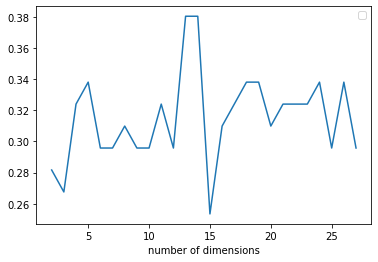

In [15]:
plt.plot(allDim,accDim)
plt.xlabel("number of dimensions")
plt.legend()